# Quantum Ansatz Stretching Algorithm (QASA)

In [120]:
# Imports
import math
import cmath
%matplotlib inline
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from numpy import linalg as la
from scipy import linalg as sla
from qiskit import *
from IPython.display import clear_output

from qiskit.quantum_info.synthesis import two_qubit_cnot_decompose as two_qubit_decomp

In [2]:
def dict_sv(psi):
    n = len(psi)
    dic = {}
    for i in range(n):
        binary = str(np.binary_repr(i))
        binary = '0'*int(np.log2(n)-len(binary)) + binary
        dic[binary] = psi[i]*np.conj(psi[i])

    return dic

In [3]:
def dicts_sv(psi):
    n = len(psi)
    dics = []
    for i in range(n):
        dic = {}
        binary = str(np.binary_repr(i))
        binary = '0'*int(np.log2(n)-len(binary)) + binary
        dic[binary] = psi[i]*np.conj(psi[i])
        dics.append(dic)
        
    return dics

In [4]:
def not_transpose(u_list):
    return u_list[0],u_list[1],u_list[2]

In [5]:
def transpose(u_list):
    return u_list[0], u_list[2] + np.pi, u_list[1] + np.pi

In [6]:
def get_phases(psi):
    n = len(psi)
    p_list = []
    for i in range(n):
        phi = np.angle(psi[i])
        if phi < 0:
            phi = 2*np.pi + phi
        p_list.append(phi/(2*np.pi))
        
    return(p_list)

In [7]:
# Factor out global phase 
def factor_gp(psi): 
    gp = np.exp(1j*np.angle(psi[0]))
    psi[0] = np.absolute(psi[0])
    for i in range(1,len(psi)):
        psi[i] /= gp
        
    return psi

## Ricochet Trick Demonstration

In [8]:
def ric_demo1(u_list):
    
    # Create a circuit
    n = 2
    q = QuantumRegister(n,'q')
    circ = QuantumCircuit(q)
    
    # Create Bell-state
    circ.h(q[0])
    circ.cx(q[0],q[1])

    t0, p0, l0 = not_transpose(u_list[0])
    t1, p1, l1 = not_transpose(u_list[1])
    circ.u3(t0,p0,l0,q[0])
    circ.u3(t1,p1,l1,q[0])

    # Get statevector 
    backend = BasicAer.get_backend('statevector_simulator')
    result = execute(circ, backend).result()
    psi = result.get_statevector()
    
    psi = factor_gp(psi)

    phases = get_phases(psi)

    color_map = mp.cm.get_cmap('plasma')

    dic = dict_sv(psi)
    plt.bar(dic.keys(), dic.values(), 0.5, color=color_map(phases))
    plt.show()
    
    return circ.draw(output='mpl')

In [9]:
def ric_demo2(u_list):
    
    # Create a circuit
    n = 2
    q = QuantumRegister(n,'q')
    circ = QuantumCircuit(q)
    
    # Create Bell-state
    circ.h(q[0])
    circ.cx(q[0],q[1])

    t0, p0, l0 = transpose(u_list[0])
    t1, p1, l1 = not_transpose(u_list[1])
    circ.u3(t0,p0,l0,q[1])
    circ.u3(t1,p1,l1,q[0])
    
#     circ.swap(q[0],q[1])

    # Get statevector 
    backend = BasicAer.get_backend('statevector_simulator')
    result = execute(circ, backend).result()
    psi = result.get_statevector()
    
    psi = factor_gp(psi)

    phases = get_phases(psi)

    color_map = mp.cm.get_cmap('plasma')

    dic = dict_sv(psi)
    plt.bar(dic.keys(), dic.values(), 0.5, color=color_map(phases))
    plt.show()
    
    return circ.draw(output='mpl')

In [ ]:
# Generate random single-qubit gate parameters
m = 2 # Number of single-qubit gates
u_list = []
for i in range(m):
    theta = np.random.uniform(0,np.pi)
    phi = np.random.uniform(0,2*np.pi)
    lamb = np.random.uniform(0,2*np.pi)
    u_list.append([theta,phi,lamb])

In [ ]:
ric_demo1(u_list)

In [ ]:
ric_demo2(u_list)

## Four Single-Qubit Example

In [251]:
def p_mat(i):
    
    p_mat_list = [np.matrix([[0,1],[1,0]],dtype=complex), np.matrix([[0,-1j],[1j,0]],dtype=complex), np.matrix([[1,0],[0,-1]],dtype=complex)]
    
    return p_mat_list[i-1]

In [252]:
def exp_par(t,term):

    q = QuantumRegister(5,'q')
    c = ClassicalRegister(5,'c')
    circ = QuantumCircuit(q,c)

    circ.h(q[1])
    circ.h(q[3])

    circ.cx(q[1],q[2])
    circ.cx(q[3],q[4])

    circ.barrier()

    circ.u3(t[1][0],t[1][1],t[1][2],q[1]) # B
    circ.u3(t[0][0],t[0][2]+np.pi,t[0][1]+np.pi,q[2]) # A^T
    circ.u3(t[3][0],t[3][1],t[3][2],q[3]) # D
    circ.u3(t[2][0],t[2][2]+np.pi,t[2][1]+np.pi,q[4]) # C^T

    circ.barrier()

    circ.h(q[0])

    circ.cx(q[0],q[1])
    circ.cx(q[0],q[4])

    circ.h(q[0])

    circ.barrier()

    circ.cx(q[1],q[4])
    circ.h(q[1])

    circ.barrier()
    
    ## Rotate basis for tomorgraphy
    
    # Apply H for X
    if term == 'X':
        circ.u3(np.pi/2,0,np.pi,q[3])

    # Apply HS^(dagger) for Y    
    elif term == 'Y':
        circ.u3(np.pi/2,0,np.pi/2,q[3]) 

    # Apply nothing for Z
    elif term == 'Z':
        pass
    
    circ.barrier()

    circ.measure(q[1],c[1])
    circ.measure(q[2],c[2])
    circ.measure(q[3],c[3])
    circ.measure(q[4],c[4])
    # circ.measure(q,c)

    backend = BasicAer.get_backend('qasm_simulator')
    result = execute(circ, backend, shots=20000).result()
    counts = result.get_counts()

    return (counts['00000']-counts['01000'])/(counts['00000']+counts['01000'])

#     return circ.draw(output='mpl')

In [253]:
def exp_ser(t,term):

    q = QuantumRegister(1,'q')
    c = ClassicalRegister(1,'c')
    circ = QuantumCircuit(q,c)

    for i in range(4):
        circ.u3(t[i][0],t[i][1],t[i][2],q[0])
        circ.barrier()
    
    ## Rotate basis for tomorgraphy
    
    # Apply H for X
    if term == 'X':
        circ.u3(np.pi/2,0,np.pi,q[0])

    # Apply HS^(dagger) for Y    
    elif term == 'Y':
        circ.u3(np.pi/2,0,np.pi/2,q[0]) 

    # Apply nothing for Z
    elif term == 'Z':
        pass

    circ.measure(q,c)

    backend = BasicAer.get_backend('qasm_simulator')
    result = execute(circ, backend,shots=20000).result()
    counts = result.get_counts()
    
    return (counts['0']-counts['1'])/(counts['0']+counts['1'])

#     return circ.draw(output='mpl')

In [254]:
def tomo_par(t):
    
    dm = np.identity(2,dtype=complex)
    
    p_list = ['X','Y','Z']
    
    for i in range(1,4):
        dm += exp_par(t,p_list[i-1]) * p_mat(i)
        
    dm /= 2
    
    return dm

In [255]:
def tomo_ser(t):
    
    dm = np.identity(2,dtype=complex)
    
    p_list = ['X','Y','Z']
    
    for i in range(1,4):
        dm += exp_ser(t,p_list[i-1]) * p_mat(i)
        
    dm /= 2
    
    return dm

In [256]:
t = [[],[],[],[]]
for i in range(4):
    for j in range(3):
        t[i].append(np.random.uniform(0,2*np.pi))

print(t)

[[0.808981655839908, 5.617475369082635, 3.969201633947063], [3.3854816667745666, 2.5372388532864623, 3.0970043934163876], [4.678343838797262, 2.6332176747569838, 0.6786935981736315], [0.7859726668410216, 3.445827545422753, 2.79145036768112]]


In [257]:
dm_par = tomo_par(t)
dm_ser = tomo_ser(t)

In [260]:
print(la.norm(dm_par-dm_ser))
print(np.real(np.trace(np.conj(dm_par).T @ dm_ser)))

0.022940286208648034
1.002456939403068


## Two Double-Qubit Example

Functions for creating bell state circuits, random single and double qubit gates, and taking transpose

In [26]:
# Create bell states
def bell_state(circ,i,j):
    circ.h(i)
    circ.cx(i,j)

In [ ]:
# angles is a list that must be at least of length 15
def two_qubit(circ, i, j, angles):
    circ.u3(angles[0], angles[1], angles[2], i)
    circ.u3(angles[3], angles[4], angles[5], j)
    circ.cx(j,i)
    circ.rz(angles[6],i)
    circ.ry(angles[7],j)
    circ.cx(i,j)
    circ.ry(angles[8],j)
    circ.cx(j,i)
    circ.u3(angles[9], angles[10], angles[11], i)
    circ.u3(angles[12], angles[13], angles[14], j)
    
def two_qubit_transpose(circ, i, j, angles):
    circ.u3(-angles[12],angles[14],angles[13], j)
    circ.u3(-angles[9],angles[11],angles[10], i)
    circ.cx(j,i)
    circ.ry(-angles[8], j)
    circ.cx(i,j)
    circ.ry(-angles[7],j)
    circ.rz(angles[6],i)
    circ.cx(j,i)
    circ.u3(-angles[3],angles[5],angles[4],j)
    circ.u3(-angles[0],angles[2],angles[1],i)

In [ ]:
n = 3

# 15 angles to create double qubit gate, via Vatan-Williams decomp
gate = np.zeros((4,15))
for i in range(0,4):
    for j in range(0,15):
        gate[i,j] = 2*np.pi*np.random.rand()

# Initialize circuits
q1 = QuantumRegister(2*n,'q')
c1 = ClassicalRegister(2*n,'c')
circ1 = QuantumCircuit(q1,c1)

q2 = QuantumRegister(2*n,'q')
c2 = ClassicalRegister(2*n,'c')
circ2 = QuantumCircuit(q2,c2)

for line in range(0,n):
    bell_state(circ1,line,line+n)
    bell_state(circ2,line,line+n)
    
circ1.barrier()
circ2.barrier()

two_qubit(circ1,0,1,gate[0,:])
two_qubit(circ1,3,4,gate[2,:])
circ1.barrier()
two_qubit(circ1,1,2,gate[1,:])
two_qubit(circ1,4,5,gate[3,:])


two_qubit_transpose(circ2,4,5,gate[1,:])
circ2.barrier()
two_qubit_transpose(circ2,3,4,gate[0,:])
circ2.barrier()
two_qubit(circ2,3,4,gate[2,:])
circ2.barrier()
two_qubit(circ2,4,5,gate[3,:])

circ1.draw(output='mpl')

In [ ]:
circ2.draw(output='mpl')

Run each circuit

In [ ]:
backend = BasicAer.get_backend('statevector_simulator')
result1 = execute(circ1, backend).result()
psi1 = result1.get_statevector()

result2 = execute(circ2, backend).result()
psi2 = result2.get_statevector()

psi1 = factor_gp(psi1)
psi2 = factor_gp(psi2)

phases1 = get_phases(psi1)
phases2 = get_phases(psi2)

color_map = mp.cm.get_cmap('plasma')

dic1 = dict_sv(psi1)
plt.bar(dic1.keys(), dic1.values(), 0.5, color=color_map(phases1))
plt.show()

In [ ]:
dic2 = dict_sv(psi2)
plt.bar(dic2.keys(), dic2.values(), 0.5, color=color_map(phases2))
plt.show()

## Time-Evolution Application

### Ising-Model Hamiltonian

Our example Hamiltonian is the 4-site Ising model with no external field:

$$
\begin{align*}
H = \sum_{i<j=1}^4h_{ij}
\end{align*}
$$

where

$$
\begin{align*}
h_{ij} \equiv J_{ij}(\sigma_i\cdot\sigma_j) = J_{ij}(X_iX_j+Y_iY_j+Z_iZ_j)
\end{align*}
$$

The time-evolution operator is

$$
\begin{align*}
U(t) 
&= 
\exp\{-iHt\}
\\
&= 
\exp\left\{-i\sum_{i<j=1}^4h_{ij}t\right\}
\\
&=
\prod_{i<j=1}^4u_{ij}
+ \mathcal{O}(t^2)
\end{align*}
$$

where

$$
\begin{align*}
u_{ij} \equiv \exp\left\{-ih_{ij}t\right\}
\end{align*}
$$

In [203]:
def kron_list(p_list):
    x = p_list[0]
    for i in range(1,len(p_list)):
        x = np.kron(x,p_list[i])
        
    return x

In [204]:
def string_to_mat(p_list):
    
    for p in range(len(p_list)):
        if p_list[p] == 'I':
            p_list[p] = I
        if p_list[p] == 'X':
            p_list[p] = X
        elif p_list[p] == 'Y':
            p_list[p] = Y
        elif p_list[p] == 'Z':
            p_list[p] = Z
            
    return p_list

In [205]:
I = np.matrix([[1,0],[0,1]],dtype=complex)
X = np.matrix([[0,1],[1,0]],dtype=complex)
Y = np.matrix([[0,-1j],[1j,0]],dtype=complex)
Z = np.matrix([[1,0],[0,-1]],dtype=complex)

swap = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])
fswap = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,-1]])

In [206]:
def h(i,j,J):
    
    h_mat = np.zeros((2**4,2**4),dtype=complex)

    for p in range(3):
        p_list = ['X','Y','Z']
        h_list = ['I','I','I','I']
        h_list[i] = p_list[p]
        h_list[j] = p_list[p]
        
        h_string = string_to_mat(h_list)

        h_mat += J[i][j] * kron_list(h_string)

    return h_mat

In [207]:
def U_0(J,t):
    
    H = np.zeros((2**4,2**4),dtype=complex)
    
    for i in range(4):
        for j in range(i,4):
            H += h(i,j,J)
            
    return sla.expm(-1j*H*t)

In [208]:
def u(i,j,J,t):
    
    p_list = [X,Y,Z]
    
    paulis = np.zeros((4,4),dtype=complex)
    for p in range(3):
        paulis += np.kron(p_list[p],p_list[p])
        
    h = J[i][j] * paulis
    
    return sla.expm(-1j*h*t)

In [209]:
def U_1(J,t):
    
    U = np.zeros((2**4,2**4),dtype=complex)
    
    for i in range(4):
        for j in range(i,4):
            U *= sla.expm(-1j*h(i,j,J,t))
            
    return U

In [210]:
def J_mat():
    
    J = np.zeros((4,4),dtype=complex)
    
    for i in range(4):
        for j in range(i,4):
            J[i][j] = np.random.uniform(-1,1)
            
    return J

### Circuit

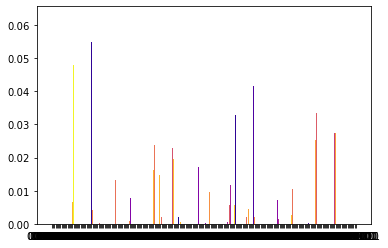

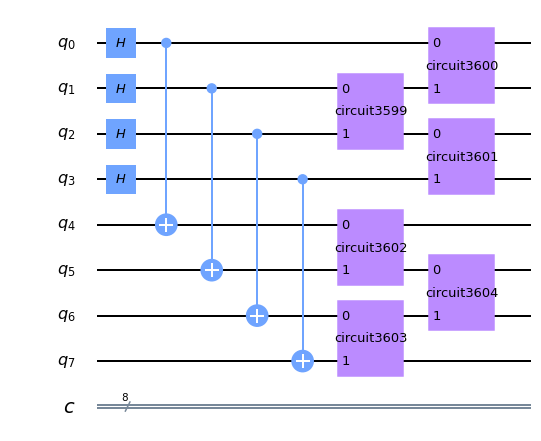

In [249]:
n = 4
t = 1

# Initialize circuits
q = QuantumRegister(2*n,'q')
c = ClassicalRegister(2*n,'c')
circ = QuantumCircuit(q,c)

for line in range(0,n):
    bell_state(circ,line,line+n)

circ.append(two_qubit_decomp((u(0,3,J,t) @ fswap).T),[q[1],q[2]])  
circ.append(two_qubit_decomp((u(0,1,J,t) @ fswap).T),[q[0],q[1]]) 
circ.append(two_qubit_decomp((u(2,3,J,t) @ fswap).T),[q[2],q[3]]) 

circ.append(two_qubit_decomp(u(1,3,J,t) @ fswap),[q[4],q[5]]) 
circ.append(two_qubit_decomp(u(0,2,J,t) @ fswap),[q[6],q[7]]) 
circ.append(two_qubit_decomp(u(1,2,J,t) @ fswap),[q[5],q[6]])  

backend = BasicAer.get_backend('statevector_simulator')
result = execute(circ, backend).result()
psi = result.get_statevector()

#     return psi

psi = factor_gp(psi)

phases = get_phases(psi)

color_map = mp.cm.get_cmap('plasma')

dic = dict_sv(psi)
plt.bar(dic.keys(), dic.values(), 0.5, color=color_map(phases))
plt.show()

circ.draw(output='mpl')

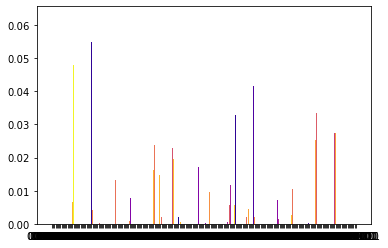

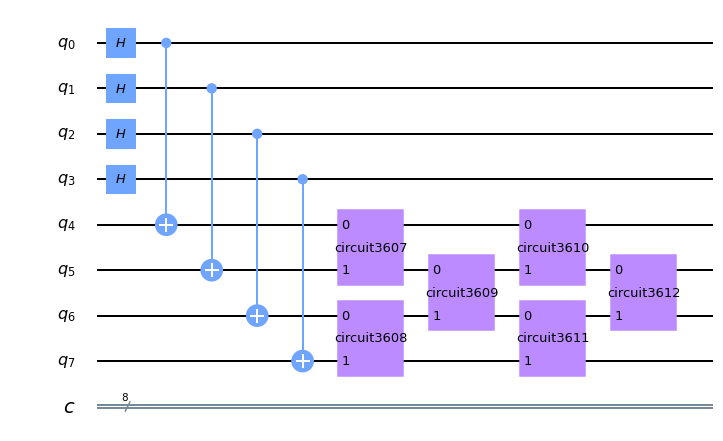

In [250]:
n = 4
t = 1

# Initialize circuits
q = QuantumRegister(2*n,'q')
c = ClassicalRegister(2*n,'c')
circ = QuantumCircuit(q,c)

for line in range(0,n):
    bell_state(circ,line,line+n)

circ.append(two_qubit_decomp((u(0,1,J,t) @ fswap).T),[q[4],q[5]])  
circ.append(two_qubit_decomp((u(2,3,J,t) @ fswap).T),[q[6],q[7]]) 
circ.append(two_qubit_decomp((u(0,3,J,t) @ fswap).T),[q[5],q[6]]) 

circ.append(two_qubit_decomp(u(1,3,J,t) @ fswap),[q[4],q[5]]) 
circ.append(two_qubit_decomp(u(0,2,J,t) @ fswap),[q[6],q[7]]) 
circ.append(two_qubit_decomp(u(1,2,J,t) @ fswap),[q[5],q[6]])  

backend = BasicAer.get_backend('statevector_simulator')
result = execute(circ, backend).result()
psi = result.get_statevector()

#     return psi

psi = factor_gp(psi)

phases = get_phases(psi)

color_map = mp.cm.get_cmap('plasma')

dic = dict_sv(psi)
plt.bar(dic.keys(), dic.values(), 0.5, color=color_map(phases))
plt.show()

circ.draw(output='mpl')